# Building Dataset

In [1]:
def count_ngrams(lines, min_length=2, max_length=4):
    """
    Iterate through given lines iterator (file object or list of
    lines) and return n-gram frequencies. The return value is a dict
    mapping the length of the n-gram to a collections.Counter
    object of n-gram tuple and number of times that n-gram occurred.
    Returned dict includes n-grams of length min_length to max_length.
    """
    
    def tokenize(string):
        """
        Convert string to lowercase and split into words (ignoring
        punctuation), returning list of words.
        """
        return string.lower().split()

    import collections, re, sys, time

    lengths = range(min_length, max_length + 1)
    ngrams = {length: collections.Counter() for length in lengths}
    queue = collections.deque(maxlen=max_length)

    # Helper function to add n-grams at start of current queue to dict
    def add_queue():
        current = tuple(queue)
        for length in lengths:
            if len(current) >= length:
                ngrams[length][current[:length]] += 1

    # Loop through all lines and words and add n-grams to dict
    for line in lines:
        for word in tokenize(line):
            queue.append(word)
            if len(queue) >= max_length:
                add_queue()

    # Make sure we get the n-grams at the tail end of the queue
    while len(queue) > min_length:
        queue.popleft()
        add_queue()

    return ngrams

def cloudwords(ngrams_questions):
    """
    """
    import matplotlib as mpl
    from wordcloud import WordCloud, STOPWORDS
    mpl.rcParams['font.size']=12                
    mpl.rcParams['savefig.dpi']=100          
    mpl.rcParams['figure.subplot.bottom']=.1 
    rcParams['figure.figsize'] = 5, 5

    for n in list(ngrams_questions.keys())[1:]:
        plt.subplot(2, 1, n-2)

        ngram_count = [(' '.join(x).title().replace(' ', ''), ngrams_questions[n][x]) 
                        for x in list(ngrams_questions[n].keys()) if ngrams_questions[n][x] > 100]

        ngram_text = []
        for x in ngram_count:
            ngram_text += [x[0]]*int(x[1])
        random.shuffle(ngram_text)
        ngram_text = ' '.join(ngram_text)


        wordcloud = WordCloud(background_color='white',
                              max_font_size=40).generate(ngram_text)

        fig = plt.figure(1)
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.tight_layout()
    plt.savefig('wordclouds.png')

def analyze_questions(DataDiz = None) :
    """
    """
    AllQuestions = {}
    for key in DataDiz:
        question = DataDiz[key]['question'].replace(' ', '')
        question = (question + '|' 
                    + DataDiz[key]['domain'][0].replace(' ', '_') + '|'
                    + DataDiz[key]['relation'])
        if question not in AllQuestions:
            AllQuestions[question] = [(DataDiz[key]['answer'], key)]
        else:
            AllQuestions[question] += [(DataDiz[key]['answer'], key)]    
    MostFrequentQ = {}
    UniqueQ = {}
    AnnoyingQ = {}
    for q in AllQuestions:
        # Count Answers
        answers = list(zip(*AllQuestions[q]))[0]
        count = Counter(answers)
        ranking = count.most_common()
        # MORE THAN ONE answer
        if len(count) > 1:
            # Looking at the Answers distribution
            ranking = count.most_common()
            # Case where the Freq of one answer is greater than the others (>1)
            if ranking[0][1] > 1:
                # Taking the most frequent answer as the right one for the Model
                MostFrequentQ[q] = (ranking[0], len(AllQuestions[q]))
            else:
                # Looking at the Questions which the right answer is not defined
                AnnoyingQ[q] = (AllQuestions[q], len(AllQuestions[q]))
        # Questions with ONLY ONE answer
        elif len(count) == 1:
            UniqueQ[q] = (ranking[0], len(AllQuestions[q]))

    return AllQuestions, MostFrequentQ, UniqueQ, AnnoyingQ

In [2]:
import pandas as pd
import os, json, pickle, string, seaborn, random
from collections import Counter
from matplotlib.pyplot import rcParams
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import pos_tag
import numpy as np
import matplotlib.pyplot as plt
seaborn.set_style('darkgrid')
%matplotlib inline

MainPath = 'C:/Users/Francesco/Desktop/chatbot/'
path = MainPath + 'chatbot_data/others/'
with open(path + 'DataDiz.json', 'r') as f: DataDiz = json.load(f)

In [3]:
len(DataDiz)

658946

In [4]:
specials = set(string.punctuation) - {'?', '.', '-', "'", '&', ',', "'"}
specials.update({'チ',
 '乌',
 '玄',
 '米',
 '茶',
 '药',
 '�'})

print(specials)

{'+', '%', '!', '/', '*', '|', '}', '_', '乌', '`', '玄', ';', ':', '"', '\\', '^', '药', 'チ', ')', '<', ']', '{', '(', '=', '>', '[', '�', '米', '@', '#', '茶', '$', '~'}


In [5]:
keysWithoutSpecial = list(filter(lambda hashcode: not any(s in DataDiz[hashcode]['question'] for s in specials) 
                                 and not any(s in DataDiz[hashcode]['answer'] for s in specials), DataDiz))
len(keysWithoutSpecial)

641445

In [6]:
DataDizWS = {hashcode: DataDiz[hashcode] for hashcode in keysWithoutSpecial}

print('-'*20 + 'UPDATE' + '-'*20)
print('Discarded observations: %s'%(len(DataDiz) - len(DataDizWS)))
print('Discarded observations: %s'%(1 -len(DataDizWS)/len(DataDiz)))
print('-'*46)

--------------------UPDATE--------------------
Discarded observations: 17501
Discarded observations: 0.02655908071374591
----------------------------------------------


In [7]:
list(filter(lambda x: DataDizWS[x]['question'].strip()[-1] != '?', DataDizWS))

[]

In [8]:
DataDizCleaned = {}
for hashcode in DataDizWS:
    # considering only the answer longer than one character
    if len(DataDizWS[hashcode]['answer']) > 1: 
        # normalizing yes/no answer
        if DataDizWS[hashcode]['answer'].lower().strip() == 'yes': DataDizWS[hashcode]['answer'] = 'yes'
        if DataDizWS[hashcode]['answer'].lower().strip() == 'no': DataDizWS[hashcode]['answer'] = 'no' 
        one_dict = DataDizWS[hashcode]
        # removing '?' at the end of the question
        if '?' == one_dict['question'].strip()[-1]:
            one_dict['question'] = one_dict['question'].strip()[:-1].strip()
        else:
            one_dict['question'] = one_dict['question'].strip()
        # removing the punctuation for sentences as 'Rome is in Italy .'
        if DataDizWS[hashcode]['answer'].strip().split()[-1] in string.punctuation:
            one_dict['answer'] = DataDizWS[hashcode]['answer'].strip()[:-1]
        # removing the punctuation for sentences as 'Rome is in Italy.'    
        elif DataDizWS[hashcode]['answer'].strip()[-1] in string.punctuation:
            one_dict['answer'] = DataDizWS[hashcode]['answer'].strip()[:-1]
        else:
            one_dict['answer'] = DataDizWS[hashcode]['answer'].strip()
        DataDizCleaned[hashcode] = one_dict

# Scatter-plot Q&A

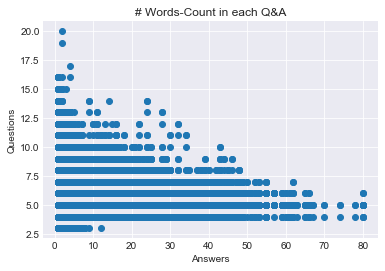

In [9]:
lst_QA = [(DataDizCleaned[hashcode]['question'], DataDizCleaned[hashcode]['answer'], hashcode) 
          for hashcode in DataDizCleaned if DataDizCleaned[hashcode]['answer'] not in ['yes', 'no']]

len_QA = [(len(x.split()), len(y.split()), z) for x,y,z in lst_QA]

lenQ,lenA, _ = list(zip(*len_QA))
plt.scatter(lenA, lenQ)
plt.title('# Words-Count in each Q&A')
plt.xlabel('Answers')
plt.ylabel('Questions')
plt.show()

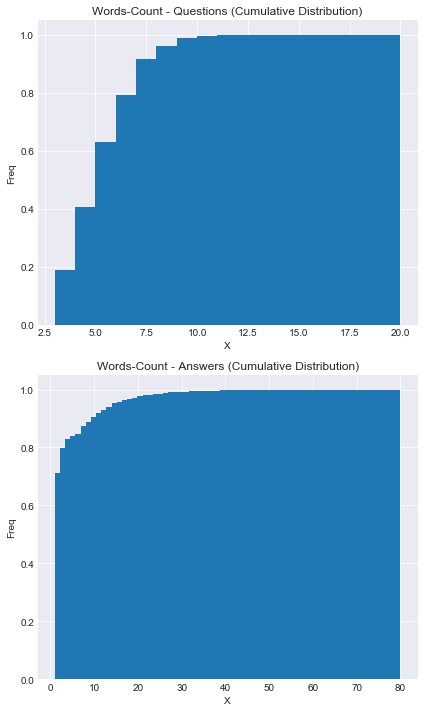

In [10]:
rcParams['figure.figsize'] = 6, 10
plt.subplot(2, 1, 1)
plt.hist(lenQ, bins=len(set(lenQ)), cumulative=True,density=True)
plt.title('Words-Count - Questions (Cumulative Distribution)')
plt.xlabel('X')
plt.ylabel('Freq')
plt.subplot(2, 1, 2)
plt.hist(lenA, bins=len(set(lenA)), cumulative=True,density=True)
plt.title('Words-Count - Answers (Cumulative Distribution)')
plt.xlabel('X')
plt.ylabel('Freq')
plt.tight_layout()

plt.savefig('cum_distr_QA.png')
#plt.show()

In [11]:
# Q
dfQ = pd.DataFrame.from_records(list(Counter(lenQ).items()), columns= ['Len', 'Freq'])
dfQ.sort_values(by = 'Len', ascending=True, inplace=True)
dfQ['Percentage'] = dfQ['Freq'].cumsum()/dfQ['Freq'].sum()
# A
dfA = pd.DataFrame.from_records(list(Counter(lenA).items()), columns= ['Len', 'Freq'])
dfA.sort_values(by = 'Len', ascending=True, inplace=True)
dfA['Percentage'] = dfA['Freq'].cumsum()/dfA['Freq'].sum()

display(dfQ.head(10))
display(dfA.head(20))

lenQ_with_hashcode_YN = [(len(DataDizCleaned[hashcode]['question'].split()), hashcode) 
          for hashcode in DataDizCleaned if DataDizCleaned[hashcode]['answer'] in ['yes', 'no']]

,Len,Freq,Percentage
3,3,55982,0.187056
0,4,65664,0.406462
2,5,67316,0.631389
4,6,48471,0.793347
5,7,36636,0.915761
1,8,13277,0.960124
6,9,8732,0.989301
7,10,2208,0.996679
8,11,721,0.999088
9,12,163,0.999632


,Len,Freq,Percentage
0,1,141791,0.473774
2,2,71521,0.712751
5,3,25505,0.797972
1,4,9258,0.828906
20,5,3121,0.839334
15,6,1730,0.845115
4,7,3818,0.857872
3,8,4621,0.873313
8,9,4377,0.887938
10,10,5142,0.905119


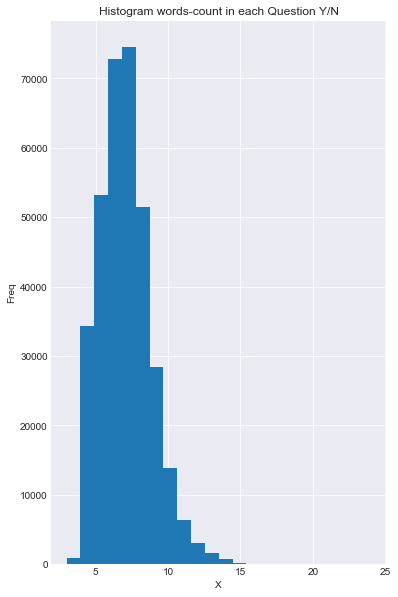

In [12]:
#YN length questions
lenQ_YN, _ = list(zip(*lenQ_with_hashcode_YN))
plt.hist(lenQ_YN, bins=len(set(lenQ_YN)))
plt.title('Histogram words-count in each Question Y/N')
plt.xlabel('X')
plt.ylabel('Freq')
plt.show()

In [13]:
# Results - len(Q) <= 10 and len(A) <= 16
filtered_QA = list(zip(*list(filter(lambda x : x[0]<=10 and x[1] <=16, len_QA))))[2]
filtered_QA_YN = list(zip(*lenQ_with_hashcode_YN))[1]
# split Yes/No from the others
DataDizNoOut = {hashcode: DataDizCleaned[hashcode] for hashcode in filtered_QA}
DataDizNoOut_YN = {hashcode: DataDizCleaned[hashcode] for hashcode in filtered_QA_YN}

print('-'*20 + 'UPDATE' + '-'*20)
print('Portion of the new dataset: %s'%((len(filtered_QA) + len(filtered_QA_YN))/len(DataDizCleaned)))
print('Obs in the new Dataset: %s' %(len(filtered_QA) + len(filtered_QA_YN)))
print('Discarded observations: %s' %(len(DataDizCleaned) - len(filtered_QA) - len(filtered_QA_YN)))
print('-'*46)

--------------------UPDATE--------------------
Portion of the new dataset: 0.9788755671276447
Obs in the new Dataset: 627841
Discarded observations: 13549
----------------------------------------------


Remove meaningless Q&A

In [14]:
# tokenized
tokenized_answers = {}
for hashcode in DataDizNoOut:
    answer = DataDizNoOut[hashcode]['answer']
    if answer not in tokenized_answers:
        tokenized_answers[answer] = {}
        tokenized_answers[answer]['hashcode'] = [hashcode]
        tokenized_answers[answer]['tokenized'] = pos_tag([answer.split()[-1]])
    else:
        tokenized_answers[answer]['hashcode'].append(hashcode)

In [15]:
# CC IN MD + 'be' + 'the'
keys_DataDizLastWordParsed = []
count = 0
tags_to_remove = ['CC', 'DT', 'IN', 'MD']
words_to_remove = ['the', 'be']
removed = []
for ta in tokenized_answers:
    if tokenized_answers[ta]['tokenized'][0][1] not in tags_to_remove:
        if tokenized_answers[ta]['tokenized'][0][0] not in words_to_remove:
            keys_DataDizLastWordParsed += tokenized_answers[ta]['hashcode']
        else:
            count += len(tokenized_answers[ta]['hashcode'])
            removed += [ta]
            
    else:
        count += len(tokenized_answers[ta]['hashcode']) 
        removed += [ta]

useless = []
DataDizLastWordParsed = {x: DataDizNoOut[x] 
                         for x in keys_DataDizLastWordParsed 
                         if DataDizNoOut[x]['answer'] not in DataDizNoOut[x]['question'] 
                        }

print('-'*20 + 'UPDATE' + '-'*20)
print('Portion of the new dataset: %s'%((len(DataDizLastWordParsed) + len(filtered_QA_YN))/len(DataDizCleaned)))
print('Obs in the new Dataset: %s' %(len(DataDizLastWordParsed) + len(filtered_QA_YN)))
print('Discarded observations: %s' %(len(DataDizCleaned) - len(filtered_QA) - len(filtered_QA_YN)))
print('-'*46)

--------------------UPDATE--------------------
Portion of the new dataset: 0.9614368792778185
Obs in the new Dataset: 616656
Discarded observations: 13549
----------------------------------------------


In [16]:
examples_removed = ['It can be',
                    'line in',
                    'state of',
                    'property of',
                    'city of',
                    'province of']
for ans in examples_removed:
    print(DataDizNoOut[tokenized_answers[ans]['hashcode'][0]]['question'] 
          + '? - ' +  
          DataDizNoOut[tokenized_answers[ans]['hashcode'][0]]['answer'])
    print()

How can I use IAST? - It can be

What is Hardt Railway? - line in

Where is located Dachau concentration camp? - state of

What is a mass? - property of

Where is City of Armagh High School? - city of

Where is located Enonkoski? - province of



In [17]:
useless = [x for x in DataDizNoOut if DataDizNoOut[x]['answer'] in DataDizNoOut[x]['question']]
random.seed(121)
random.shuffle(useless)
for hashcode in useless[:5]:
    print(DataDizNoOut[hashcode]['question'] 
          + '? - ' +  
          DataDizNoOut[hashcode]['answer'])
    print()

What is an example of a television broadcasting? - television

Where is Ossipee Lake located? - Ossipee

What is Religious clothing? - clothing

Where is Linden Railway Station placed? - Linden

Where can Perimeter Center be found? - Perimeter



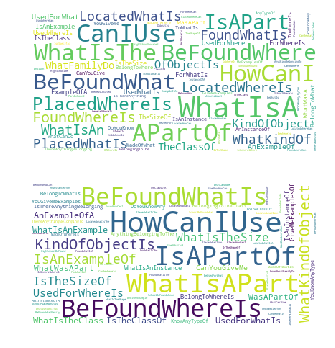

In [18]:
questions = [DataDizLastWordParsed[hashcode]['question'] for hashcode in DataDizLastWordParsed]
questions = list(set(questions))
ngrams_questions = count_ngrams(lines=questions)
cloudwords(ngrams_questions)

In [19]:
sorted(ngrams_questions[2].items(), key=lambda x: x[1], reverse = True)[:10]

[(('where', 'is'), 72038),
 (('what', 'is'), 68302),
 (('where', 'can'), 11919),
 (('be', 'found'), 11907),
 (('is', 'a'), 10444),
 (('used', 'for'), 7058),
 (('part', 'of'), 6982),
 (('a', 'part'), 6976),
 (('can', 'i'), 6936),
 (('i', 'use'), 6936)]

In [20]:
sorted(ngrams_questions[4].items(), key=lambda x: x[1], reverse = True)[:10]

[(('how', 'can', 'i', 'use'), 6406),
 (('what', 'is', 'a', 'part'), 4991),
 (('is', 'a', 'part', 'of'), 4991),
 (('be', 'found', 'where', 'is'), 4463),
 (('be', 'found', 'what', 'is'), 4224),
 (('what', 'kind', 'of', 'object'), 3963),
 (('kind', 'of', 'object', 'is'), 3963),
 (('is', 'an', 'example', 'of'), 3311),
 (('what', 'is', 'the', 'size'), 2663),
 (('is', 'the', 'size', 'of'), 2663)]

In [21]:
# open-ended multiple choice
DataDizE = {hashcode: DataDizLastWordParsed[hashcode] 
            for hashcode in DataDizLastWordParsed
            if 'example' in DataDizLastWordParsed[hashcode]['question']
            or 'part of' in DataDizLastWordParsed[hashcode]['question']
            or 'instance of' in DataDizLastWordParsed[hashcode]['question']
            or 'can be' in DataDizLastWordParsed[hashcode]['question']
           }
DataDizLastWordParsed = {x: DataDizLastWordParsed[x] for x in DataDizLastWordParsed 
                         if x not in DataDizE}

# 1. General

In [22]:
(AllQuestions,
 MostFrequentQ,
 UniqueQ, 
 AnnoyingQ) = analyze_questions(DataDiz=DataDizLastWordParsed)

# 2. YesNo

In [23]:
(AllQuestions_YN,
 MostFrequentQ_YN,
 UniqueQ_YN, 
 AnnoyingQ_YN) = analyze_questions(DataDiz=DataDizNoOut_YN)
# Considering only UniqueQ_YN

In [24]:
distributionYN = [ ('|'.join(q_d_r.split('|')[1:]), UniqueQ_YN[q_d_r][0][0]) for q_d_r in UniqueQ_YN ]
with open(MainPath +'chatbot_data/others/IdxDomains.json', 'r') as f: IdxDomains = json.load(f)
with open(MainPath +'chatbot_data/others/IdxRelations.json', 'r') as f: IdxRelations = json.load(f)

In [25]:
distributionYNDiz = {}

for obs in distributionYN:
    if obs[0] not in distributionYNDiz:
        distributionYNDiz[obs[0]] = {}
        distributionYNDiz[obs[0]]['yes'] = 0
        distributionYNDiz[obs[0]]['no'] = 0
        distributionYNDiz[obs[0]][obs[-1]] = 1
    else:
        distributionYNDiz[obs[0]][obs[-1]] += 1

distributionYNDiz = {x: distributionYNDiz[x] for x in distributionYNDiz 
                     if sum(distributionYNDiz[x].values()) >1 and
                     all(n > 0 for n in distributionYNDiz[x].values()) == True
                    
                    }

dfYN = pd.DataFrame.from_dict(distributionYNDiz).T
dfYN['tot'] = dfYN['yes'] + dfYN['no']
dfYN.sort_values('tot', ascending=False, inplace=True)

print('Count:\n')
print('Number of pairs Domain-Relation in the Dataset: %s'%len(dfYN))
print('---')
print('Possible Number of pairs Domain-Relation: %s'%(len(IdxDomains)*len(IdxRelations)))
print('---')
print('Ratio covered in the dataset: %s'%(100*(len(dfYN)/(len(IdxDomains)*len(IdxRelations)))))
display(dfYN.head())
print('Ratio of Geography and places | PLACE: %s' %(dfYN.loc['Geography_and_places|PLACE']['tot']/dfYN['tot'].sum()))

df_distribution = pd.DataFrame(sorted(Counter(distributionYN).items(), key = lambda x:x[1], reverse = True),index=None)
df_distribution.columns = ['name', 'count']
df_distribution['ratio'] = df_distribution['count']/sum(df_distribution['count'].values)

Count:

Number of pairs Domain-Relation in the Dataset: 238
---
Possible Number of pairs Domain-Relation: 544
---
Ratio covered in the dataset: 43.75


,no,yes,tot
Geography_and_places|PLACE,34,41850,41884
Geography_and_places|PART,19056,1397,20453
Transport_and_travel|PART,16604,607,17211
Transport_and_travel|PLACE,6,13070,13076
Geography_and_places|GENERALIZATION,516,12390,12906


Ratio of Geography and places | PLACE: 0.13109069057


C:\Users\Francesco\Anaconda2\envs\tensorflowDEF\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


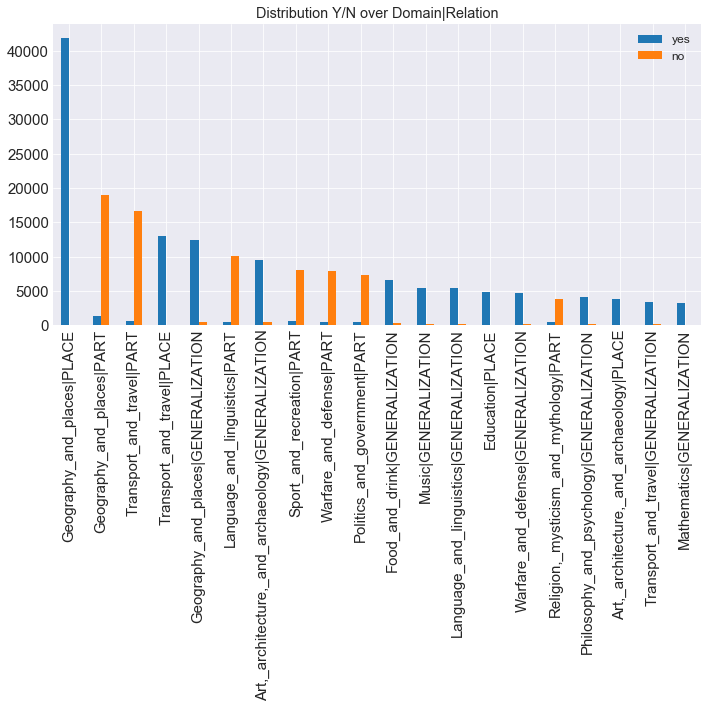

In [26]:
import matplotlib
labsize = 15
matplotlib.rc('xtick', labelsize=labsize) 
matplotlib.rc('ytick', labelsize=labsize) 
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams['figure.figsize'] = 10, 10
dfYN.head(20)[['yes', 'no']].plot.bar()
plt.title('Distribution Y/N over Domain|Relation')
plt.savefig('distribution_yn_overDR.png')

In [27]:
# Reduce 'yes' from places of the 50%
Balanced_YN = {}
count = 0
for k in DataDizNoOut_YN:
    if (DataDizNoOut_YN[k]['answer'] == 'yes' and
        'Geography and places'== DataDizNoOut_YN[k]['domain'][0] and
        DataDizNoOut_YN[k]['relation'] == 'PLACE'):
        if count < 20*10**3:
            Balanced_YN[k] = DataDizNoOut_YN[k]
            count += 1
    else:
        Balanced_YN[k] = DataDizNoOut_YN[k]
            

print('Discarded obs: ' +str (len(DataDizNoOut_YN) - len(Balanced_YN)))

Discarded obs: 21877


0
yes    209145
no     111088
Name: 1, dtype: object

C:\Users\Francesco\Anaconda2\envs\tensorflowDEF\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


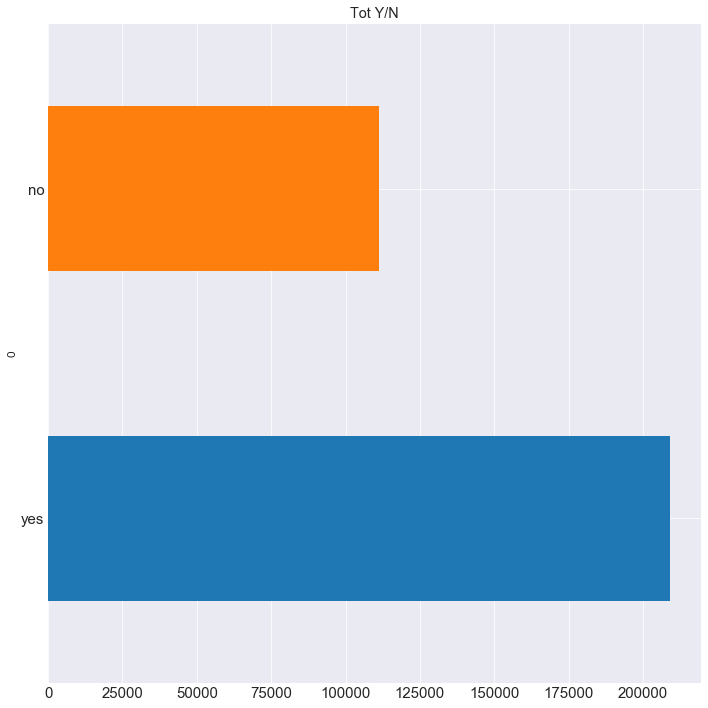

In [28]:
tot_YN = pd.DataFrame.from_dict(list(Counter([Balanced_YN[x]['answer'] for x in Balanced_YN]).items())).T
tot_YN.columns = tot_YN.loc[0]
tot_YN.T[1].plot.barh()
display(tot_YN.loc[1])
plt.title('Tot Y/N')
plt.show()

# 3. Examples/PartOf

In [29]:
# It's no-sense here considering the split
AllQuestions_E, _, _, _ = analyze_questions(DataDiz=DataDizE)

In [30]:
HashCodeE = {
    q: {
        'hashcode': list(zip(*AllQuestions_E[q]))[1],
        'answer': list(set(list(zip(*AllQuestions_E[q]))[0])),
        'pattern': 'PATTERN' + str(idx)
    }
    for idx, q in enumerate(AllQuestions_E.keys())
}
# PatternAnswer DIZ
PatternAnswer = {HashCodeE[q]['pattern']: HashCodeE[q]['answer'] for q in HashCodeE}

In [31]:
for q in HashCodeE:
    for hashcode in HashCodeE[q]['hashcode']:
        DataDizE[hashcode]['answer'] = HashCodeE[q]['pattern']

# Summary

In [32]:
totQ = len(AllQuestions) + len(AllQuestions_YN) + len(AllQuestions_E)
summaryDf = pd.DataFrame(columns=[['Count', 'MostFrequentQ', 'AnnoyingQ', 'UniqueQ']])
summaryDf.loc['General'] =  [len(AllQuestions), len(MostFrequentQ), len(AnnoyingQ), len(UniqueQ)]
summaryDf.loc['YN'] =  [len(AllQuestions_YN), len(MostFrequentQ_YN), len(AnnoyingQ_YN), len(UniqueQ_YN)]
summaryDf.loc['E'] =  [len(AllQuestions_E)] + [None]*3
summaryDfPercentage = pd.DataFrame(columns=[['Count', 'MostFrequentQ', 'AnnoyingQ', 'UniqueQ']])
summaryDfPercentage.loc['General (%)'] = (100*summaryDf.loc['General']/totQ) 
summaryDfPercentage.loc['YN (%)'] = (100*summaryDf.loc['YN']/totQ) 
summaryDfPercentage.loc['E (%)'] = (100*summaryDf.loc['E']/totQ) 

In [33]:
display(summaryDf)
display(summaryDfPercentage)

,Count,MostFrequentQ,AnnoyingQ,UniqueQ
General,192149,811,28735,162603
YN,333337,0,4,333333
E,18544,NaN,NaN,NaN


,Count,MostFrequentQ,AnnoyingQ,UniqueQ
General (%),35.319560,0.149073,5.281878,29.888609
YN (%),61.271805,0.000000,0.000735,61.271070
E (%),3.408636,NaN,NaN,NaN


- AnnoyingQ = Enriching
- Dataset1 = 50k(~E*3) + 100k from YN + 100k from General = 250k of obs. Dataset 1 used for predicting type of Question and Relation.
- Data to Save: General(MostFrequentQMore50 + UniqueQ) + YN(Unique_YN) + E

In [34]:
# Enriching = {'domain|relation': {'question': {'answer1': 'synset_id', 'answer2': 'synset_id',...}...}...}

enriching_data = {}
for q_d_r in AnnoyingQ:
    domain_relation = '|'.join(q_d_r.split('|')[1:])
    if domain_relation not in enriching_data:
        enriching_data[domain_relation] = {}
        question = DataDizLastWordParsed[AnnoyingQ[q_d_r][0][0][1]]['question']
        enriching_data[domain_relation][question] = {'c2': {}, 
                                                     'c1': DataDizLastWordParsed[AnnoyingQ[q_d_r][0][0][1]]['concepts'][0],
                                                     'solved': 'no'}
        for obs in AnnoyingQ[q_d_r][0]:
            enriching_data[domain_relation][question]['c2'][obs[0]] = DataDizLastWordParsed[obs[1]]['concepts'][1]
with open(path + 'enriching_data.json', 'w') as outfile: json.dump(enriching_data, outfile)

In [35]:
# Dataset1: 3MC + YN + general = 50k + 100k + 100k

# MC
dataset1_MC = [(DataDizE[k]['question'] + ' | ' + DataDizE[k]['domain'][0],
              DataDizE[k]['relation'] + '_' + 'E') for k in DataDizE]
dataset1_MC = 3*list(set(dataset1_MC))
# YN
dataset1_YN = [(Balanced_YN[k]['question'] + ' | '+ Balanced_YN[k]['domain'][0],
                 Balanced_YN[k]['relation'] + '_' + 'YN') for k in Balanced_YN]
# general
general = {}
for q_d_r in MostFrequentQ:
    hashcode = list(filter(lambda x: x[0] == MostFrequentQ[q_d_r][0][0], AllQuestions[q_d_r]))[0][1]
    general[hashcode] = DataDizLastWordParsed[hashcode]
for q_d_r in UniqueQ:
    hashcode = list(filter(lambda x: x[0] == UniqueQ[q_d_r][0][0], AllQuestions[q_d_r]))[0][1]
    general[hashcode] = DataDizLastWordParsed[hashcode]

dataset1_general = [(general[k]['question'] + ' | '+ general[k]['domain'][0],
                 general[k]['relation'] + '_' + 'G') for k in general]
    
random.seed(123)
path = MainPath + 'chatbot_data/data/'
# 100k + 100k + 50k
dataset1 = dataset1_MC + random.sample(dataset1_YN, 10**5) + random.sample(dataset1_general, 10**5)
pickle.dump( dataset1, open(path + "dataset1.p", "wb" ) )

In [36]:
"""
Save Diz: 
- DataDizYN
- DataDizE
- general
- PatternAnswer
"""
path = MainPath + 'chatbot_data/data/'
with open(path + 'DataDizYN.json', 'w') as outfile: json.dump(Balanced_YN, outfile)
with open(path + 'DataDizE.json', 'w') as outfile: json.dump(DataDizE, outfile)
with open(path + 'general.json', 'w') as outfile: json.dump(general, outfile)
with open(path + 'PatternAnswer.json', 'w') as outfile: json.dump(PatternAnswer, outfile)